# Exercise 1
 <p><div class="lev1"><a href="#Task-A.-Another-LEGO-brick-in-the-wall"><span class="toc-item-num">Task A.&nbsp;&nbsp;</span>Another LEGO brick in the wall</a></div>
 <p><div class="lev1"><a href="#Task-B.-Drop-the-Bike"><span class="toc-item-num">Task B.&nbsp;&nbsp;</span>Drop the Bike</a></div>

In [1]:
# Add your imports here
# Importing pandas and numpy
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = 'data'

## Task A. Another LEGO brick in the wall

LEGO is a popular brand of toy building bricks. They are often sold in sets in order to build a specific object. Each set contains a number of parts in different shapes, sizes and colors. This database contains information on which parts are included in different LEGO sets. It was originally compiled to help people who owned some LEGO sets already figure out what other sets they could build with the pieces they had.

This dataset contains the official LEGO colors, parts, inventories (i.e., sets of LEGO parts which assembled create an object in the LEGO world) and sets (i.e., sets of LEGO inventories which assembled create a LEGO ecosystem). The schema of the dataset can be shown in the following UML diagram: 

![lego-schema](lego-schema.png)

In this task you have to apply the following Data Wrangling pipeline:
1. Load your data into `Pandas`
* Explore it and clean its dirty parts
* Use it to answer a set of queries

Each of these subtasks are described in detail below.

### A1. Loading phase
Load all the csv files into different `DataFrames`. Use meaningful names for your `DataFrames` (e.g., the respective filenames).

*Hint: You can load files without first unzipping them (for `Pandas` version >= 0.18.1).*

In [3]:
LEGO_DATA_FOLDER = DATA_FOLDER + '/lego'

In [4]:
# Write your code here
colors = pd.read_csv(LEGO_DATA_FOLDER + "/colors.csv.zip")
inventories = pd.read_csv(LEGO_DATA_FOLDER + "/inventories.csv.zip")
inventory_parts = pd.read_csv(LEGO_DATA_FOLDER + "/inventory_parts.csv.zip")
inventory_sets = pd.read_csv(LEGO_DATA_FOLDER + "/inventory_sets.csv.zip")
part_categories = pd.read_csv(LEGO_DATA_FOLDER + "/part_categories.csv.zip")
parts = pd.read_csv(LEGO_DATA_FOLDER + "/parts.csv.zip")
sets = pd.read_csv(LEGO_DATA_FOLDER + "/sets.csv.zip")
themes = pd.read_csv(LEGO_DATA_FOLDER + "/themes.csv.zip")

### A2. Cleaning phase
Explore the following columns from your dataset:

1. sets: year
* inventory_parts: quantity

What is the time range of the sets? 
What is the average quantity of the inventory parts? 
Do you see any inconsistencies? 
Provide code that detects and cleans such inconsistencies and validates the coherence of your dataset. 

In [5]:
# 1. Cleaning Sets: year

print(sets.year.head(20))

# Make all negative years positive
sets['year'] = sets['year'].apply(lambda x: x[1:] if x[0] == "-" else x)

# Delete last digit if year have 5 digits
sets['year'] = sets['year'].apply(lambda x: x[:-1] if len(x) == 5 else x)

# Change 70s to NAN 
sets['year'] = sets['year'].apply(lambda x: np.nan if len(x) == 3 else x)

# change years to datetime
sets['year'] = sets['year'].apply(lambda x: pd.to_datetime(x).year)

# check the type of sets year - should be float64
print(sets.year.dtype)




0       70s
1      1978
2      1987
3      1979
4      1979
5      1979
6      1979
7     19788
8      1976
9      1976
10     1976
11     1965
12     1985
13     1976
14     1965
15     1968
16     1968
17     1968
18     1999
19     1968
Name: year, dtype: object
float64


In [6]:
# Calculate time range
first_year = sets.year.min()
last_year = sets.year.max()
time_range = last_year - first_year
print('The time range is ' + str(time_range) + " years, between " + str(np.int(first_year)) + " and " + str(np.int(last_year)) + ".")

The time range is 67.0 years, between 1950 and 2017.


In [7]:
# Cleaning inventory_parts: quantity
# Replace all infinite values in cells with ifinity to 0
inventory_parts.quantity = inventory_parts.quantity.replace([np.inf, -np.inf], 0.0)

# Calculate the average 
average = np.around(np.average(inventory_parts.quantity),2)

# Count amount of values equaling zero
quantity_zero = (inventory_parts['quantity'] == 0).sum()
percentage_zero = np.around(quantity_zero/inventory_parts.quantity.sum() * 100,2)

# print results
print('The quantity average is ' + str(average) + 
'\n' + str(percentage_zero) + ' % of the values are equal to zero' )


The quantity average is 2.77
10.08 % of the values are equal to zero


__\* Briefly explain your approach here \*__

#### Cleaning sets by the column year
1. Print years to see examples of inconsistencies in the data. Examples of inconsistencies are negative years, years with five digits and years written as decade+"s"(70s, 80s, etc).
2. Cleaning:
    1. First, all negative years are turned positive.
    2. Secondly, all years with 5 digits are turned into 4 digit numbers. We assume that the last digit has been repeated and therefore remove it. For example, 20011 is turned into 2001.
    3. Lastly we changed all values to NAN where the year is written as decade+"s", as there is no way of knowing in which year of the decade the set is from.
    4. Change values to datetime
3. Calculate the time range for the sets
    
#### Cleaning inventory_parts by the column quantity
1. Print quantity to see examples of inconsistencies in the data. An example of an inconsistency is that some of the quantities are written as "-inf".
2. Cleaning:
    1. Set all quantities with the value "-inf" to 0.0 instead, as 0.0 is not used in the rest of the array. This way the data will remain but functions such as count, sum etc. can be applied to the column.
3. Calculate the average quantity
4. Calculate the percentage of zero values


### A3. Querying phase
Answer the following queries using the functionality of `Pandas`:

1. List the ids of the inventories that belong to sets that contain cars. (*Hint: Find a smart way to distinguish which sets contain cars based on the sets' name*).
* Plot the distribution of part categories as a (horizontal) bar chart. Restrict yourself to the 20 largest part categories (in terms of the number of parts belonging to the category).
* Find the dominant color of each set. Then, plot using a (horizontal) bar chart, the number of sets per dominant color. Color each bar with the respective color that it represents.
* Create a scatter plot of the *luminance*\* of the sets vs their publishing year. What do you observe for the years 1980-1981? How do you interpret what you see?

\*The luminance of a color is a [measure of brightness](https://en.wikipedia.org/wiki/Luminance) which, given its RGB representation, can be computed as follows:

$luminance = \sqrt{0.299*R^2 + 0.587*G^2 + 0.114*B^2}$

In [148]:
# Task 1
# Get sets with "car\s" in the name:
cars = r'^(?:.*\s)?cars?(?:\s.*)?$'
car_sets = sets[sets.name.str.contains(cars, flags=re.IGNORECASE)]

# Merge with inventory_sets to find the inventory ids
inventory_sets_cars = pd.merge(car_sets, inventory_sets, left_on='id', right_on='set_id')

cars_inventories = inventory_sets_cars.inventory_id.drop_duplicates().tolist()

print('The ids of the inventories that belong to sets that contain cars  are: ' +  str(cars_inventories))



The ids of the inventories that belong to sets that contain cars  are: [13941, 10158, 13083, 5358, 13380, 8202, 16131, 1716, 10406, 14174, 7430, 14711, 12851, 10515, 14919, 2814, 15010, 5904, 7151, 11966, 8140, 6066, 1649, 6530, 14011, 2917, 6086, 1371, 13427, 528, 14493, 908, 2559, 6296, 10028, 12110, 1401, 1418, 1732, 3109, 3764, 4430, 4969, 5857, 11861, 13696, 15694, 7363, 4051, 8820, 7881, 4187, 13355, 13398, 8348, 9426, 12437, 500]


Text(0.5,1,'Distribution of parts')

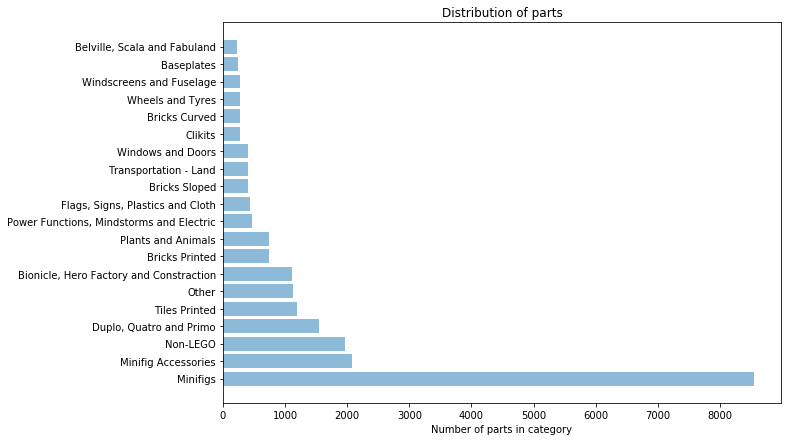

In [9]:
# Task 2 
# Count how many parts there are in each category. Select the 20 largest categories 
part_ids = parts.part_cat_id.value_counts().head(20)

# Join the most used parts with the part categories to get access to the part category names:
names = part_ids.to_frame().join(part_categories.set_index('id')).name.values

# Plotting
y_pos = np.arange(len(names))
x_pos = part_ids.values

plt.rcParams["figure.figsize"] = [10, 7]
plt.barh(y_pos, x_pos, align='center', alpha=0.5)
plt.yticks(y_pos, names)
plt.xlabel('Number of parts in category')
plt.title('Distribution of parts')

In [15]:
# Task 3 - Getting the right data

# Merge inventory_sets and inventory_parts on inventory_id
# Making sure that the quantity columns are relabeled (quantity from inventory_sets the 
# denotes #inventories, quantity from inventory_parts denotes #parts)
df = inventory_sets.join(inventory_parts.set_index('inventory_id'), 
                         how="left", 
                         on="inventory_id",
                         lsuffix="_inventories", 
                         rsuffix="_parts")

# Remove rows in which the number of parts are 0. (There are never any rows in which the quantity_inventories are 0)
df = df[df['quantity_parts'] != 0]

# Create a new column with the total quantity of parts by multiplying the quantity of inventories and the quantity
# of parts for a set
df['total_quantity'] = df.quantity_inventories * df.quantity_parts

# Remove unnecessary columns
df = df.drop(['inventory_id','quantity_inventories','part_id','quantity_parts','is_spare'], axis = 1).dropna()

# small example of the data
print(df.head(2))



     set_id  color_id  total_quantity
16  10233-1    9999.0             1.0
17  88002-1    9999.0             1.0


In [139]:
# Task 3 - Calculating the dominant color for each set
def findDominantColor(data):
    color = data.groupby('color_id').total_quantity.apply(lambda y: y.sum())
    return color.idxmax()

# create a series with the dominant color for each set
dominant_colors = df.groupby('set_id').apply(lambda set_ID: findDominantColor(set_ID))

# count the values and join with color dataframe to get the rgb values
color_distribution = dominant_colors.value_counts().to_frame(name = 'freq')
color_distribution = colors.loc[:,['id','rgb', 'name']].set_index('id').join(color_distribution).dropna()

# sort cells by freq 
color_distribution = color_distribution.sort_values('freq')


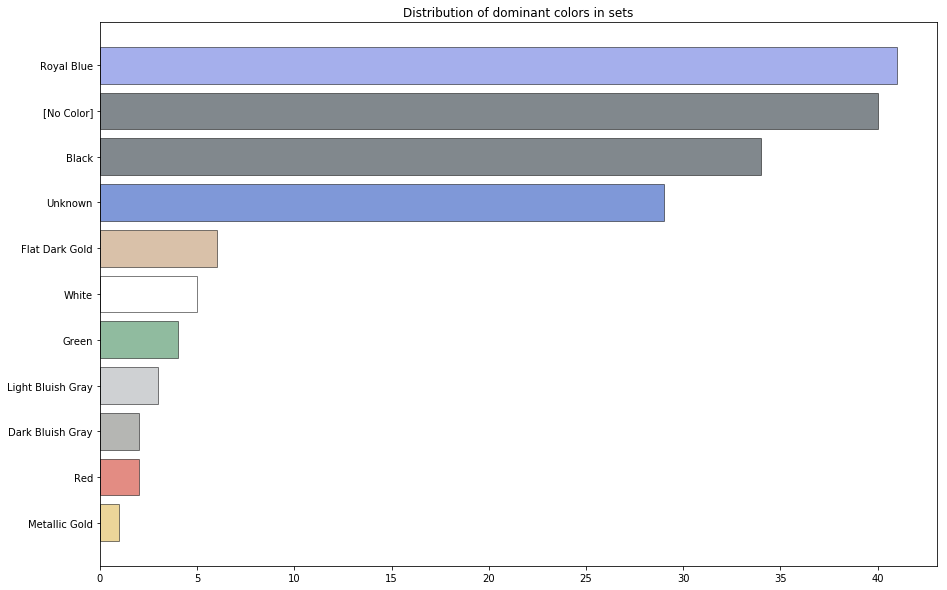

In [18]:
# Tast 3 - plot
y = color_distribution.name
y_pos = np.arange(len(y))
x = color_distribution.freq

plt.rcParams["figure.figsize"] = [15, 10]
# Use the rgb value to pick the colors for the bars
plt.barh(y_pos, x, align='center', alpha=0.5, color = '#' + color_distribution.rgb, edgecolor = 'black')
plt.yticks(y_pos, y)
plt.title('Distribution of dominant colors in sets')

plt.show()

In [140]:
dominant_colors = dominant_colors.to_frame('color_id')


In [145]:
# Task 4 - Getting the right data
#join with colors to get the rgb values
colors_clean = colors.loc[:,['id','rgb']].set_index('id')
dominant_colors_rgb = dominant_colors.reset_index().set_index('color_id').join(colors_clean).drop_duplicates()

# Join with sets to get the years
years = sets.loc[:,['id','year']]
lum_df = dominant_colors_rgb.set_index('set_id').join(years.set_index('id')).dropna()
lum_df = lum_df.loc[:, ['rgb', 'year']]


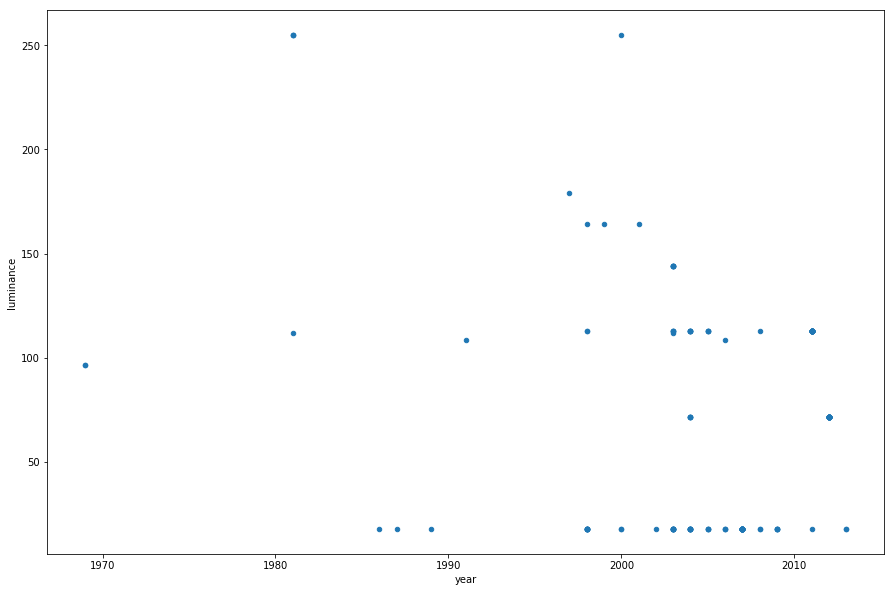

In [144]:
# Task 4 - calculate the luminance
def rgb_to_lum(x):
    R, G, B = (int(x[i:i+2], 16) for i in (0, 2, 4))
    return sqrt(0.299*(R**2) + 0.587*(G**2) + 0.114*(B**2))

# calculate the luminance based on the rgb-values
lum_df['luminance'] = lum_df['rgb'].apply(rgb_to_lum)

lum_df.plot.scatter(x='year', y='luminance')



In general the luminance is lower in the later years. In 1980-1981 the luminance isn't varied, only two different luminances are found.  


__\* Briefly explain your approach for every query here \*__

Query 1
1. Find all the sets with names including "car" or "cars" with blank space before and after. This means we obtain sets like "Shell Car Wash" even though this is not a car
2. Find the inventory ids for those sets
3. Print the list och the inventories

Query 2 
1. Count how many parts there are in each category. Select the 20 largest categories 
2. Find the category names
3. Plot the distribution of part categories

Query 3
1. Clean data and create a dataFrame with colums containing data for: set_id, color_id and total_quantity. Total_quantity is the total amount of a specific part in the specified set.
2. Find the dominant color for each set by summerizing the number of parts of the same color in the same set and then choose the color with the maximum number of parts
3. Count the number of sets that correspond to each color
4. Plot the color distrubution in a bar graph.

Query 4
1. Use the dataframe with dominant color for each set and join it with colors to get the rgb values
2. Join with sets to get the years for each set
3. Calculate the luminance for each rgb-value
4. Plot

## Task B. Drop the bike

*Los Angeles Metro* has been sharing publicly [anonymized *Metro Bike Share* trip data](https://bikeshare.metro.net/about/data/) under the [Open Database License (ODbL)](http://opendatacommons.org/licenses/odbl/1.0/).

In this task you will again perform data wrangling and interpretation.

### B1. Loading phase
Load the json file into a `DataFrame`.


In [149]:
BIKES_DATA_FOLDER = DATA_FOLDER + '/bikes'

In [150]:
# Write your code here
bikes = pd.read_json(BIKES_DATA_FOLDER + '/metro-bike-share-trip-data.json.zip')
df = bikes

### B2. Cleaning phase
Describe the type and the value range of each attribute. Indicate and transform the attributes that are `Categorical`. Are there redundant columns in the dataset (i.e., are there columns whose value depends only on the value of another column)? What are the possible pitfalls of having such columns? Reduce *data redundancy* by extracting such columns to separate `DataFrames`. Which of the two formats (the initial one or the one with reduced data redundancy) is more susceptible to inconsistencies? At the end print for each `Dataframe` the *type of each column* and it's *shape*.

__\* Briefly explain your approach here \*__

### B3. Querying phase
Answer the following queries using the functionality of `Pandas`.

1. Plot the *distribution* of the number of outgoing trips from each station in a histogram with 20 bins (Hint: each bin describes a range of counts, not stations).
* Plot histograms for the *duration* and *trip starting hour in the day* attributes. For both the *duration*  and the *trip starting hour* use *discrete 1-hour intervals*. What do you observe in each plot? What are some popular values in the *duration* plot? Explain the local maxima and the trends you observe on the *trip starting hour* plot based on human behavior.
* For each *trip route category*, calculate the proportion of trips by *passholder type* and present your results in *a stacked bar chart with normalized height*.
* Considering only trips that begin in the morning hours (before noon), plot in *a single bar chart* the proportion of trips by *passholder type* and *trip route category*. Explain any outliers you observe.
* Separate the hours of the day into two intervals that have (approximately) the same number of bikes leaving the stations. For each of the two intervals calculate the proportion of trips by *passholder type* and *trip route category*. Present your results in a `DataFrame` which has a unique, non-composite index. Does the proportion of trips depend on whether it is the first or second hour interval? Would the company have any significant benefit by creating a more complex paying scheme where monthly pass users would pay less in the first interval and (equally) more on the second one? Assume that the number of trips per interval will not change if the scheme changes.

Text(0.5,1,'Distribution of Starting Stations ID')

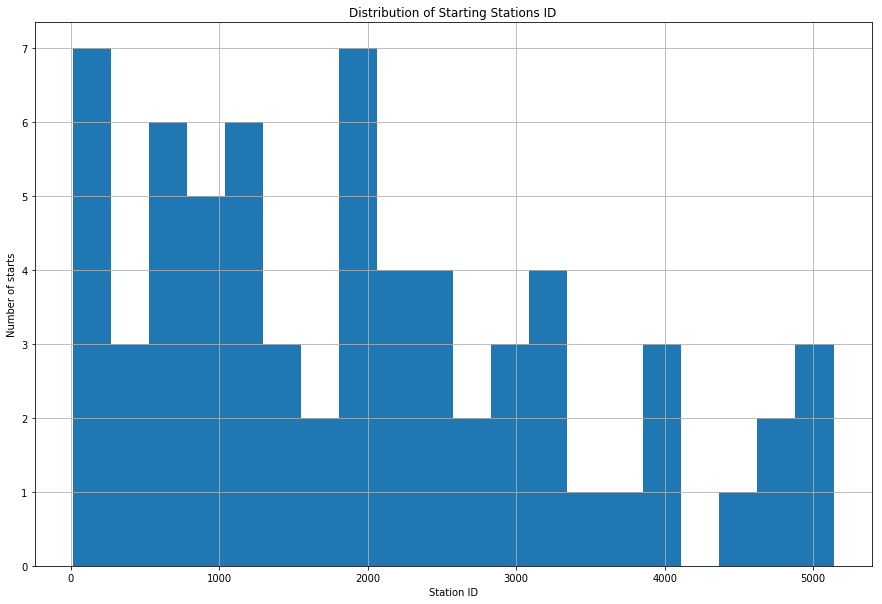

In [154]:
#Task B3.1

# Pick out the 'Starting Station ID' column and count the number of times a station has been started from.
starting_stations_count = df['Starting Station ID'].value_counts()

# Plot histogram
starting_stations_count.hist(bins=20)# Write your code here
plt.xlabel('Station ID')
plt.ylabel('Number of starts')
plt.title('Distribution of Starting Stations ID')

Text(0.5,1,'Distribution of Duration time')

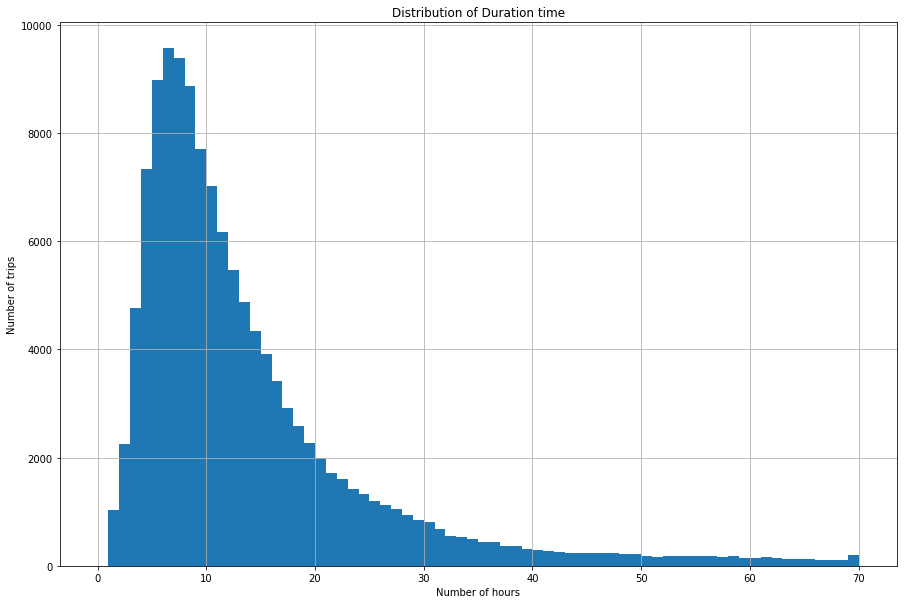

In [156]:
# Task B3.2

# Plot histograms for the duration and trip starting hour in the day attributes. 
# For both the duration and the trip starting hour use discrete 1-hour intervals. 
# What do you observe in each plot? What are some popular values in the duration plot? 
# Explain the local maxima and the trends you observe on the trip starting hour plot based on human behavior.

# Pick out duration and divide by 60 since the durations are given in minutes.
duration = df['Duration']/60

# Plot up to 70 hours. There are longer durations as well, but they are few, so the shape of the plot is the same.
duration.hist(bins=70, range=(0,70))

plt.xlabel('Number of hours')
plt.ylabel('Number of trips')
plt.title('Distribution of Duration time')


In this plot we can see that popular values of the duration are around 6-10 hours, with the local maxima at around 8 hours.
This can be explained by that people use the bikes to commute to work, staying at work for around 6-8 hours and then goes back with the bike. 

Text(0.5,1,'Distribution of Start time')

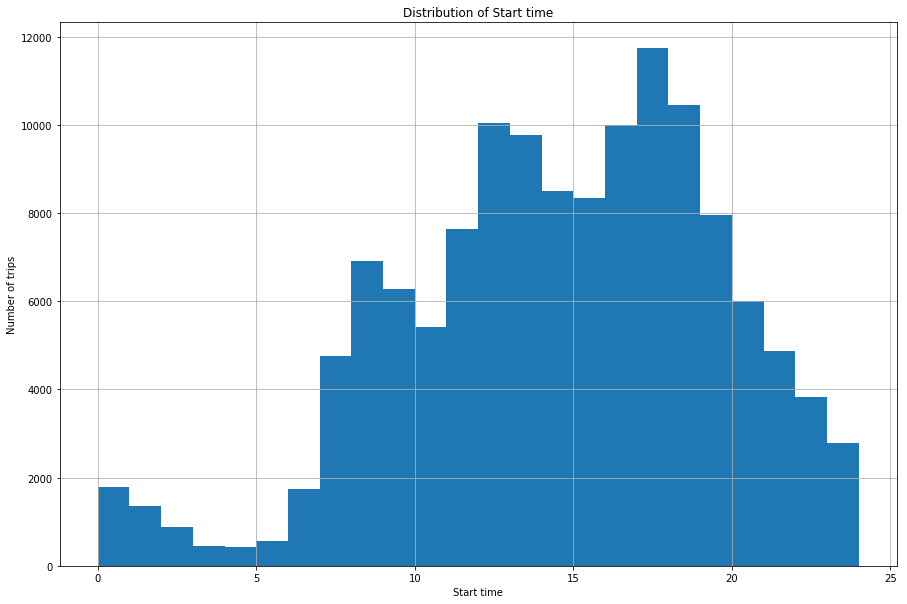

In [157]:
# Select Start times
trip_start = df['Start Time']

# Convert to datetime objects and pick out the hours.
trip_start = pd.to_datetime(trip_start).dt.hour

# Plot
trip_start.hist(bins = 24, range=(0, 24))

plt.xlabel('Start time')
plt.ylabel('Number of trips')
plt.title('Distribution of Start time')


In the graph we can see three local maximum. In the morning (8-9), at lunch time (11-13) and in the evening (16-17). These are all time periods that are related to work or school hours. We might therefore asume that a fairly large part of the users the bikes for getting to and from work/school.

__\* Briefly explain your approach for every query here \*__